In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sample-901/jini...png
/kaggle/input/sampleimage/Screenshot 2024-09-16 153207.png
/kaggle/input/butter/Butterfly.jpg
/kaggle/input/simplebutter/Simplebutter.png


Iteration 0, Loss: 6982591.099126315
Iteration 500, Loss: 883.9705052384923
Iteration 1000, Loss: 491.97401321053854
Iteration 1500, Loss: 328.72899087543396
Iteration 2000, Loss: 240.76701252091712
Iteration 2500, Loss: 195.05074959445938
Iteration 0, Loss: 6935305.20236769
Iteration 500, Loss: 904.6197637285876
Iteration 1000, Loss: 447.4689958837235
Iteration 1500, Loss: 301.8172298253332
Iteration 2000, Loss: 239.13271960225146
Iteration 2500, Loss: 197.1793689856163
Iteration 0, Loss: 6887334.660750129
Iteration 500, Loss: 773.2057923557502
Iteration 1000, Loss: 394.9860649484417
Iteration 1500, Loss: 269.27424886639596
Iteration 2000, Loss: 212.84159681361527
Iteration 2500, Loss: 178.9859955799568
Iteration 0, Loss: 7074747.644850026
Iteration 500, Loss: 89.55923351440825
Iteration 1000, Loss: 2.06605282940232
Iteration 1500, Loss: 0.16068146187688015
Iteration 2000, Loss: 0.010447983463166109
Iteration 2500, Loss: 0.0008508717567110581
Matrix Factorization - RMSE: 0.05313840880

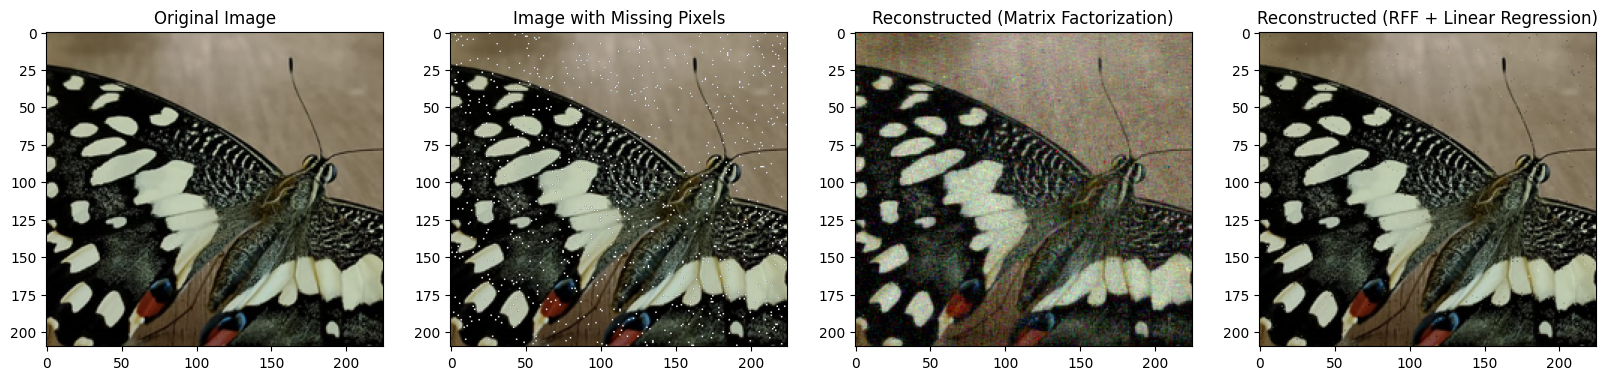

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.kernel_approximation import RBFSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and process the image (make sure the path is corrct)
img_path = '/kaggle/input/simplebutter/Simplebutter.png'  
img = torchvision.io.read_image(img_path).float() / 255.0  # Normalize between 0 and 1

img = img.to(device)

height, width = img.shape[1], img.shape[2]

# Step 1: Randomly remove 900 pixels
missing_mask = np.ones((height, width))
missing_pixels = np.random.choice(height * width, 900, replace=False)
missing_mask.flat[missing_pixels] = 0  

img_masked = img.clone()
for c in range(img.shape[0]):  # Loop over RGB channels
    img_masked[c, :, :] *= torch.tensor(missing_mask).to(device)

# Define the matrix factorization function
def factorize_channel(channel, mask, r, lr=0.01, num_iters=3000):
    h, w = channel.shape

    # Initialize W (h x r) and H (r x w) randomly
    W = torch.randn(h, r, requires_grad=True, device=device)
    H = torch.randn(r, w, requires_grad=True, device=device)

    # Optimizer
    optimizer = torch.optim.Adam([W, H], lr=lr)

    # Train the model
    for i in range(num_iters):
        optimizer.zero_grad()

        # Reconstructed image
        reconstructed_channel = torch.mm(W, H)

        # Apply mask: consider only the known pixels during training
        loss = torch.norm((reconstructed_channel - channel) * mask, 'fro') ** 2

        # Backpropagation
        loss.backward()
        optimizer.step()

        if i % 500 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")

    return W, H

# Factorize each channel using the masked image
reconstructed_channels_mf = []

for c in range(img.shape[0]):
    channel = img[c, :, :]
    mask = torch.tensor(missing_mask).to(device)  # Use the mask for missing pixels
    W, H = factorize_channel(channel, mask, r=150)
    reconstructed_channel = torch.mm(W, H).cpu().detach().numpy()
    reconstructed_channels_mf.append(reconstructed_channel)

# Stack the reconstructed channels back into an RGB image (Matrix Factorization)
reconstructed_img_mf = np.stack(reconstructed_channels_mf, axis=0)
reconstructed_img_mf = np.clip(reconstructed_img_mf, 0, 1)  # Clip to valid range
reconstructed_img_mf = np.transpose(reconstructed_img_mf, (1, 2, 0))

# Step 2: Random Fourier Features (RFF) + Linear Regression
def rff_reconstruct(img, mask, gamma=0.05, n_components=1000):
    """Reconstruct missing pixels using RFF + Linear Regression."""
    height, width = img.shape[1], img.shape[2]
    X_known = np.argwhere(mask == 1)
    X_missing = np.argwhere(mask == 0)

    # Flatten image for easy access
    img_flattened = img.reshape(img.shape[0], -1)

    reconstructed_channels_rff = []

    for c in range(img.shape[0]):  # Loop over channels (R, G, B)
        y_known = img_flattened[c, X_known[:, 0] * width + X_known[:, 1]]

        # Apply RFF to known pixel positions
        rbf_feature = RBFSampler(gamma=gamma, n_components=n_components, random_state=1)
        X_transformed = rbf_feature.fit_transform(X_known)
        X_missing_transformed = rbf_feature.transform(X_missing)

        # Train linear regression
        model = Ridge(alpha=1.0)
        model.fit(X_transformed, y_known)

        # Predict missing pixel values
        y_missing = model.predict(X_missing_transformed)

        # Reconstruct image
        img_reconstructed = img_flattened[c, :].copy()
        img_reconstructed[X_missing[:, 0] * width + X_missing[:, 1]] = y_missing
        reconstructed_channels_rff.append(img_reconstructed.reshape(height, width))

    reconstructed_img_rff = np.stack(reconstructed_channels_rff, axis=0)
    return np.clip(reconstructed_img_rff, 0, 1)  # Clip to valid range

reconstructed_img_rff = rff_reconstruct(img_masked.cpu().numpy(), missing_mask)
reconstructed_img_rff = np.transpose(reconstructed_img_rff, (1, 2, 0))

# RMSE and PSNR calculations
def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

def calculate_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    max_pixel = 1.0  # Since the image is normalized between 0 and 1
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Convert original image to CPU for RMSE/PSNR calculations
original_img = img.cpu().detach().numpy()
original_img = np.transpose(original_img, (1, 2, 0))

# Calculate RMSE and PSNR for Matrix Factorization
rmse_mf = calculate_rmse(original_img, reconstructed_img_mf)
psnr_mf = calculate_psnr(original_img, reconstructed_img_mf)

# Calculate RMSE and PSNR for RFF + Linear Regression
rmse_rff = calculate_rmse(original_img, reconstructed_img_rff)
psnr_rff = calculate_psnr(original_img, reconstructed_img_rff)

print(f"Matrix Factorization - RMSE: {rmse_mf}, PSNR: {psnr_mf} dB")
print(f"RFF + Linear Regression - RMSE: {rmse_rff}, PSNR: {psnr_rff} dB")

# Plot the original, masked, and reconstructed images
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(original_img)
ax[0].set_title('Original Image')
ax[1].imshow(np.transpose(img_masked.cpu().detach().numpy(), (1, 2, 0)))
ax[1].set_title('Image with Missing Pixels')
ax[2].imshow(reconstructed_img_mf)
ax[2].set_title('Reconstructed (Matrix Factorization)')
ax[3].imshow(reconstructed_img_rff)
ax[3].set_title('Reconstructed (RFF + Linear Regression)')
plt.show()


Iteration 0, Loss: 11625862.113876687
Iteration 1000, Loss: 198.49695584875755
Iteration 2000, Loss: 84.85644494867607
Iteration 3000, Loss: 53.07337449987981
Iteration 4000, Loss: 36.11699932135565
Iteration 5000, Loss: 24.514511522597076
Iteration 6000, Loss: 16.57236335695431
Iteration 0, Loss: 11932560.976082133
Iteration 1000, Loss: 217.99225019112583
Iteration 2000, Loss: 99.43904601188108
Iteration 3000, Loss: 58.90943698587833
Iteration 4000, Loss: 37.75579230563568
Iteration 5000, Loss: 25.341135435042286
Iteration 6000, Loss: 17.25701962725877
Iteration 0, Loss: 11550967.005983151
Iteration 1000, Loss: 169.94246719762373
Iteration 2000, Loss: 80.1202298254614
Iteration 3000, Loss: 51.162469989750356
Iteration 4000, Loss: 34.821731268011185
Iteration 5000, Loss: 23.90250558307198
Iteration 6000, Loss: 16.2368018972917
Iteration 0, Loss: 11644516.891252266
Iteration 1000, Loss: 12.87739248683555
Iteration 2000, Loss: 0.6147188708679785
Iteration 3000, Loss: 0.08791246810436704


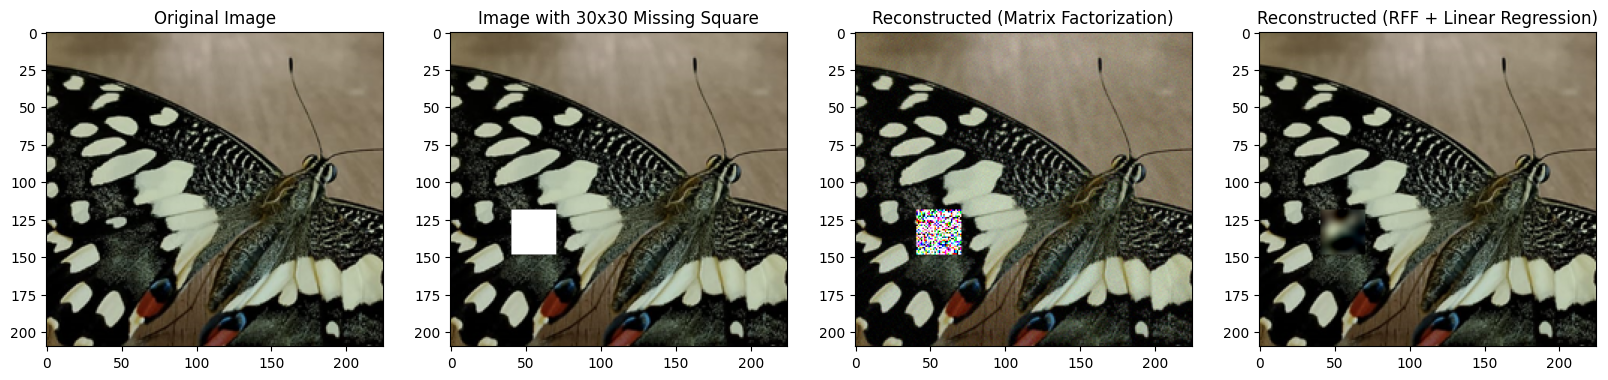

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.kernel_approximation import RBFSampler

# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and process the image (make sure the path is correct)
img_path = '/kaggle/input/simplebutter/Simplebutter.png'  # Replace with your image path
img = torchvision.io.read_image(img_path).float() / 255.0  # Normalize between 0 and 1

# Move image to the device (shape: Channels x Height x Width)
img = img.to(device)

# Get height and width of the image
height, width = img.shape[1], img.shape[2]

# Step 1: Remove a 30x30 square from the image
def remove_square(img, square_size=30):
    h, w = img.shape[1], img.shape[2]
    # Randomly select top-left corner of the square
    top_left_y = np.random.randint(0, h - square_size)
    top_left_x = np.random.randint(0, w - square_size)
    
    # Create a mask with the 30x30 square missing
    mask = np.ones((h, w))
    mask[top_left_y:top_left_y + square_size, top_left_x:top_left_x + square_size] = 0
    
    return mask, (top_left_y, top_left_x)

# Generate the mask and get the square coordinates
missing_mask, square_coords = remove_square(img.cpu().numpy())
top_left_y, top_left_x = square_coords

# Apply the mask to the image
img_masked = img.clone()
for c in range(img.shape[0]):  # Loop over RGB channels
    img_masked[c, :, :] *= torch.tensor(missing_mask).to(device)

# Define the matrix factorization function
def factorize_channel(channel, mask, r, lr=0.01, num_iters=7000):
    h, w = channel.shape

    # Initialize W (h x r) and H (r x w) randomly
    W = torch.randn(h, r, requires_grad=True, device=device)
    H = torch.randn(r, w, requires_grad=True, device=device)

    # Optimizer
    optimizer = torch.optim.Adam([W, H], lr=lr)

    # Train the model
    for i in range(num_iters):
        optimizer.zero_grad()

        # Reconstructed image
        reconstructed_channel = torch.mm(W, H)

        # Apply mask: consider only the known pixels during training
        loss = torch.norm((reconstructed_channel - channel) * mask, 'fro') ** 2

        # Backpropagation
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")

    return W, H

# Factorize each channel using the masked image
reconstructed_channels_mf = []

for c in range(img.shape[0]):
    channel = img[c, :, :]
    mask = torch.tensor(missing_mask).to(device)  # Use the mask for missing pixels
    W, H = factorize_channel(channel, mask, r=250)
    reconstructed_channel = torch.mm(W, H).cpu().detach().numpy()
    reconstructed_channels_mf.append(reconstructed_channel)

# Stack the reconstructed channels back into an RGB image (Matrix Factorization)
reconstructed_img_mf = np.stack(reconstructed_channels_mf, axis=0)
reconstructed_img_mf = np.clip(reconstructed_img_mf, 0, 1)  # Clip to valid range
reconstructed_img_mf = np.transpose(reconstructed_img_mf, (1, 2, 0))

# Step 2: Random Fourier Features (RFF) + Linear Regression
def rff_reconstruct(img, mask, square_coords, square_size=30, gamma=0.05, n_components=1000):
    """Reconstruct missing pixels using RFF + Linear Regression."""
    top_left_y, top_left_x = square_coords
    X_known = np.argwhere(mask == 1)
    X_missing = np.argwhere(mask == 0)

    # Flatten image for easy access
    img_flattened = img.reshape(img.shape[0], -1)

    reconstructed_channels_rff = []

    for c in range(img.shape[0]):  # Loop over channels (R, G, B)
        y_known = img_flattened[c, X_known[:, 0] * width + X_known[:, 1]]

        # Apply RFF to known pixel positions
        rbf_feature = RBFSampler(gamma=gamma, n_components=n_components, random_state=1)
        X_transformed = rbf_feature.fit_transform(X_known)
        X_missing_transformed = rbf_feature.transform(X_missing)

        # Train linear regression
        model = Ridge(alpha=1.0)
        model.fit(X_transformed, y_known)

        # Predict missing pixel values
        y_missing = model.predict(X_missing_transformed)

        # Reconstruct image
        img_reconstructed = img_flattened[c, :].copy()
        img_reconstructed[X_missing[:, 0] * width + X_missing[:, 1]] = y_missing
        reconstructed_channels_rff.append(img_reconstructed.reshape(height, width))

    reconstructed_img_rff = np.stack(reconstructed_channels_rff, axis=0)
    return np.clip(reconstructed_img_rff, 0, 1)  # Clip to valid range

reconstructed_img_rff = rff_reconstruct(img_masked.cpu().numpy(), missing_mask, square_coords)
reconstructed_img_rff = np.transpose(reconstructed_img_rff, (1, 2, 0))

# RMSE and PSNR calculations
def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

def calculate_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    max_pixel = 1.0  # Since the image is normalized between 0 and 1
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Convert original image to CPU for RMSE/PSNR calculations
original_img = img.cpu().detach().numpy()
original_img = np.transpose(original_img, (1, 2, 0))

# Calculate RMSE and PSNR for Matrix Factorization
rmse_mf = calculate_rmse(original_img, reconstructed_img_mf)
psnr_mf = calculate_psnr(original_img, reconstructed_img_mf)

# Calculate RMSE and PSNR for RFF + Linear Regression
rmse_rff = calculate_rmse(original_img, reconstructed_img_rff)
psnr_rff = calculate_psnr(original_img, reconstructed_img_rff)

print(f"Matrix Factorization - RMSE: {rmse_mf}, PSNR: {psnr_mf} dB")
print(f"RFF + Linear Regression - RMSE: {rmse_rff}, PSNR: {psnr_rff} dB")

# Plot the original, masked, and reconstructed images
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(original_img)
ax[0].set_title('Original Image')
ax[1].imshow(np.transpose(img_masked.cpu().detach().numpy(), (1, 2, 0)))
ax[1].set_title('Image with 30x30 Missing Square')
ax[2].imshow(reconstructed_img_mf)
ax[2].set_title('Reconstructed (Matrix Factorization)')
ax[3].imshow(reconstructed_img_rff)
ax[3].set_title('Reconstructed (RFF + Linear Regression)')
plt.show()


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.kernel_approximation import RBFSampler

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_src = '/kaggle/input/simplebutter/Simplebutter.png'
image = torchvision.io.read_image(img_src).float() / 255.0
image = image.to(dev)

h, w = image.shape[1], image.shape[2]

def drop_patch(image, patch_size=30):
    y_size, x_size = image.shape[1], image.shape[2]
    top_left_y = np.random.randint(0, y_size - patch_size)
    top_left_x = np.random.randint(0, x_size - patch_size)
    
    patch_mask = np.ones((y_size, x_size))
    patch_mask[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] = 0
    
    return patch_mask, (top_left_y, top_left_x)

mask, patch_coords = drop_patch(image.cpu().numpy())
top_y, top_x = patch_coords

masked_img = image.clone()
for ch in range(image.shape[0]):
    masked_img[ch, :, :] *= torch.tensor(mask).to(dev)

def matrix_factorize(channel, mask, rank, learning_rate=0.01, iterations=7000):
    img_h, img_w = channel.shape
    U = torch.randn(img_h, rank, requires_grad=True, device=dev)
    V = torch.randn(rank, img_w, requires_grad=True, device=dev)
    optim = torch.optim.Adam([U, V], lr=learning_rate)
    for step in range(iterations):
        optim.zero_grad()
        rec_img = torch.mm(U, V)
        loss = torch.norm((rec_img - channel) * mask, 'fro') ** 2
        loss.backward()
        optim.step()
    return U, V

def rmse_metric(orig, rec):
    return np.sqrt(np.mean((orig - rec) ** 2))

def psnr_metric(orig, rec):
    mse = np.mean((orig - rec) ** 2)
    max_pixel_val = 1.0
    psnr_val = 20 * np.log10(max_pixel_val / np.sqrt(mse))
    return psnr_val

original_image = image.cpu().detach().numpy()
original_image = np.transpose(original_image, (1, 2, 0))

r_values = [50, 100, 200, 300, 400]

fig, ax = plt.subplots(len(r_values), 3 + 1, figsize=(20, 5 * len(r_values)))

for i, r in enumerate(r_values):
    mf_reconstructed_channels = []
    for ch in range(image.shape[0]):
        img_ch = image[ch, :, :]
        ch_mask = torch.tensor(mask).to(dev)
        U, V = matrix_factorize(img_ch, ch_mask, rank=r)
        rec_ch = torch.mm(U, V).cpu().detach().numpy()
        mf_reconstructed_channels.append(rec_ch)

    reconstructed_mf = np.stack(mf_reconstructed_channels, axis=0)
    reconstructed_mf = np.clip(reconstructed_mf, 0, 1)
    reconstructed_mf = np.transpose(reconstructed_mf, (1, 2, 0))

    rff_reconstructed_img = rff_linear_reconstruct(masked_img.cpu().numpy(), mask, patch_coords)
    rff_reconstructed_img = np.transpose(rff_reconstructed_img, (1, 2, 0))

    mf_rmse = rmse_metric(original_image, reconstructed_mf)
    mf_psnr = psnr_metric(original_image, reconstructed_mf)

    rff_rmse = rmse_metric(original_image, rff_reconstructed_img)
    rff_psnr = psnr_metric(original_image, rff_reconstructed_img)

    ax[i, 0].imshow(original_image)
    ax[i, 0].set_title('Original Image')
    
    ax[i, 1].imshow(np.transpose(masked_img.cpu().detach().numpy(), (1, 2, 0)))
    ax[i, 1].set_title('Image with Missing Patch')
    
    ax[i, 2].imshow(reconstructed_mf)
    ax[i, 2].set_title(f'Reconstructed (MF r={r})')
    
    ax[i, 3].imshow(rff_reconstructed_img)
    ax[i, 3].set_title('Reconstructed (RFF)')

    print(f"Rank {r} - Matrix Factorization - RMSE: {mf_rmse}, PSNR: {mf_psnr} dB")
    print(f"Rank {r} - RFF + Linear Regression - RMSE: {rff_rmse}, PSNR: {rff_psnr} dB")

plt.tight_layout()
plt.show()


Rank 50 - Matrix Factorization - RMSE: 0.09386655688285828, PSNR: 20.54978224376947 dB
Rank 50 - RFF + Linear Regression - RMSE: 0.02129030041396618, PSNR: 33.43636420927271 dB
Rank 100 - Matrix Factorization - RMSE: 0.07652240246534348, PSNR: 22.324228070055643 dB
Rank 100 - RFF + Linear Regression - RMSE: 0.02129030041396618, PSNR: 33.43636420927271 dB
Rank 200 - Matrix Factorization - RMSE: 0.07606379687786102, PSNR: 22.376439993964098 dB
Rank 200 - RFF + Linear Regression - RMSE: 0.02129030041396618, PSNR: 33.43636420927271 dB
Rank 300 - Matrix Factorization - RMSE: 0.08810965716838837, PSNR: 21.099529771579487 dB
Rank 300 - RFF + Linear Regression - RMSE: 0.02129030041396618, PSNR: 33.43636420927271 dB
Rank 400 - Matrix Factorization - RMSE: 0.08949989080429077, PSNR: 20.963549891027657 dB
Rank 400 - RFF + Linear Regression - RMSE: 0.02129030041396618, PSNR: 33.43636420927271 dB
